In [28]:
import pandas as pd 
from matplotlib import pyplot as plt
import numpy as np

# Protein Target Space; `mytargets.csv` 

This will be the targets that will ultimately be predicted on.   

> NOTE: there are non-unique mappings from ensembl/gene_symbol to uniprot and therefore each gene_symbol will have multiple sequences - this increases the target space from ~2000 -> ~8000. We will predict on the full 8000 and then aggregate back to gene_symbol after. 

In [10]:
# genes from reactome signal transduction pathway 
genespace= open('./gene-space.txt', 'r').read().split(',')
len(genespace)

2378

In [12]:
# LINCS/CLUE gene info - filtered to protein coding only and genespace
# merge with ens2uni (can be download from ensembl.org - biomart)
geneinfo = pd.read_csv('../../data/geneinfo_beta.txt', sep='\t')[lambda x: x.gene_symbol.isin(genespace) & (x.gene_type == 'protein-coding')]
ens2uni = pd.read_csv('./ensembl2uniprot.txt', sep='\t')[['ensembl_id', 'uniprot_id']]
geneinfo = geneinfo.merge(ens2uni, on='ensembl_id', how='left')

In [13]:
# Uniprot-provided amino acid sequences 
# This can be downloaded from uniprot (https://www.uniprot.org/id-mapping/)
#   use geneinfo to select a subset of uniprot ids and paste into uniprot for sequences 
AA = pd.read_csv('./genespace_aa_seq.tsv', sep='\t')

In [14]:
# merge geneinfo and AA sequences 
geneinfo = geneinfo.merge(AA, left_on='uniprot_id', right_on='From')[['gene_symbol', 'gene_id', 'ensembl_id', 'uniprot_id', 'Gene Names', 'gene_title', 'gene_type', 'Reviewed', 'Entry Name', 'Organism', 'Length', 'Sequence']]
print(geneinfo.shape)
geneinfo.head()

(8735, 12)


,gene_symbol,gene_id,ensembl_id,uniprot_id,Gene Names,gene_title,gene_type,Reviewed,Entry Name,Organism,Length,Sequence
0,ABL2,27,ENSG00000143322,P42684,ABL2 ABLL ARG,"ABL proto-oncogene 2, non-receptor tyrosine ki...",protein-coding,reviewed,ABL2_HUMAN,Homo sapiens (Human),1182,MGQQVGRVGEAPGLQQPQPRGIRGSSAARPSGRRRDPAGRTTETGF...
1,ACVR2B,93,ENSG00000114739,Q13705,ACVR2B,activin A receptor type 2B,protein-coding,reviewed,AVR2B_HUMAN,Homo sapiens (Human),512,MTAPWVALALLWGSLCAGSGRGEAETRECIYYNANWELERTNQSGL...
2,ADCYAP1,116,ENSG00000141433,P18509,ADCYAP1,adenylate cyclase activating polypeptide 1,protein-coding,reviewed,PACA_HUMAN,Homo sapiens (Human),176,MTMCSGARLALLVYGIIMHSSVYSSPAAAGLRFPGIRPEEEAYGED...
3,ADCYAP1R1,117,ENSG00000078549,E9PFU5,ADCYAP1R1,ADCYAP receptor type I,protein-coding,unreviewed,E9PFU5_HUMAN,Homo sapiens (Human),524,MAGVVHVSLAALLLLPMAPAMHSDCIFKKEQAMCLEKIQRANELMG...
4,ADCYAP1R1,117,ENSG00000078549,C9JVH3,ADCYAP1R1,ADCYAP receptor type I,protein-coding,unreviewed,C9JVH3_HUMAN,Homo sapiens (Human),74,MAGVVHVSLAALLLLPMAPAMHSDCIFKKEQAMCLEKIQRANELMG...


In [20]:
geneinfo.to_csv('../mytargets.csv', index=False)

# Drug Space; `mydrugs.csv` 

This will be the drugs with which we will predict on.

The drugs are filtered to whatever is present in `drugspace.txt`

In [39]:
# drug space 
drugspace = open('./drug-space.txt', 'r').read().split(',')

# LINCS/CLUE compound information 
druginfo = pd.read_csv('../../data/compoundinfo_beta.txt', sep='\t')[['pert_id', 'cmap_name', 'canonical_smiles']].drop_duplicates()
druginfo = druginfo[lambda x: x.pert_id.isin(drugspace)]
druginfo = druginfo[lambda x: ~x.canonical_smiles.isna()]
druginfo = druginfo.assign(smiles_len = lambda xx: [len(x) for x in xx.canonical_smiles.values])
print(druginfo.shape)
druginfo.head()

(668, 4)


,pert_id,cmap_name,canonical_smiles,smiles_len
605,BRD-K43002773,GDC-0068,C[C@@H]1C[C@H](C2=C1C(=NC=N2)N3CCN(CC3)C(=O)[C...,75
608,BRD-A50998626,palomid-529,COc1ccc(COc2cc3oc(=O)c4cc(ccc4c3cc2OC)C(C)O)cc1,47
610,BRD-K70301465,ibrutinib,Nc1ncnc2n(nc(-c3ccc(Oc4ccccc4)cc3)c12)[C@@H]1C...,61
626,BRD-K68407802,KIN001-055,COc1cc2ncnc(Nc3cc(Br)c(O)c(Br)c3)c2cc1OC,40
627,BRD-K42828737,sunitinib,CCN(CC)CCNC(=O)c1c(C)[nH]c(C=C2/C(=O)Nc3ccc(F)...,54


In [40]:
druginfo.to_csv('../mydrugs.csv', index=False)

# EDA

In [41]:
# how many pairwase predictions will we have to make? 
druginfo.shape[0]*geneinfo.shape[0]

5834980

99th percentile AA length: 2500.6399999999994


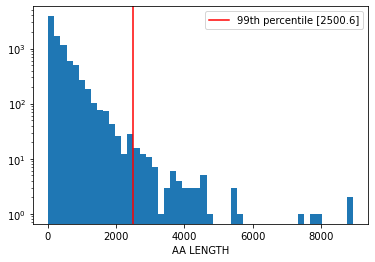

In [42]:
# amino acid length distribution 

a_q99 = np.quantile(geneinfo.Length.values, 0.99)
print('99th percentile AA length:', a_q99)

plt.figure()
plt.hist(geneinfo.Length.values, bins=50)
plt.yscale('log')
plt.xlabel('AA LENGTH')
plt.axvline(a_q99, c='r', label=f'99th percentile [{a_q99:.1f}]')
plt.legend()
plt.show()

99th percentile SMILES length: 164.99000000000012


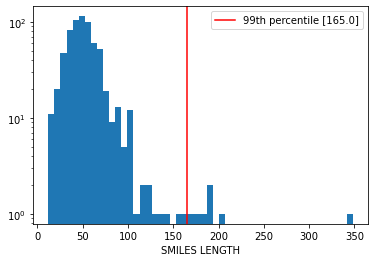

In [43]:
# smiles length dist 

d_q99 = np.quantile(druginfo.smiles_len.values, 0.99)
print('99th percentile SMILES length:', d_q99)

plt.figure()
plt.hist(druginfo.smiles_len.values, bins=50)
plt.xlabel('SMILES LENGTH')
plt.yscale('log')
plt.axvline(d_q99, c='r', label=f'99th percentile [{d_q99:.1f}]')
plt.legend()
plt.show()